In [22]:
#Totes les llibreries que necessitem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions


In [23]:
#Carreguem les dades, train i test
train=pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Estudi de Normalitat

In [25]:
#Estudi de normalitat en Age i Fare
#Per mostres més grans de 50 Kolmogorov-Smirnov, mitja coneguda poblacional.

stats.kstest(train['Age'], 'norm')

C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\marco\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


KstestResult(statistic=nan, pvalue=nan)

In [26]:
#Mitja poblacional no coneguda, Lilliefors
from statsmodels.stats.diagnostic import lilliefors

lilliefors(train['Fare'], dist='norm', pvalmethod=None)

C:\Users\marco\Anaconda3\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)


(0.28184804098597455, 6.069408967120122e-202)

In [27]:
#Shapiro
stats.shapiro(train['Age'])

(nan, 1.0)

In [28]:
stats.shapiro(train['Age'])

(nan, 1.0)

In [29]:
#Estudi de homogeneïtat Age i Fare
#Bartlett

stats.bartlett(train['Age'], train['Fare'])

BartlettResult(statistic=1100.752914443349, pvalue=2.2659125646568713e-241)

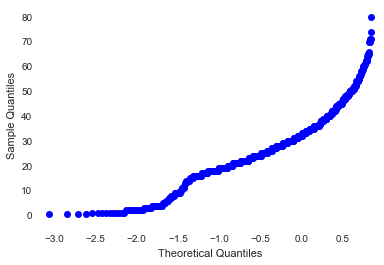

In [30]:
# Anàlisi visual, distribució dels quantils
from statsmodels.graphics.gofplots import qqplot

qqplot(train['Age'], line='s')
plt.show()

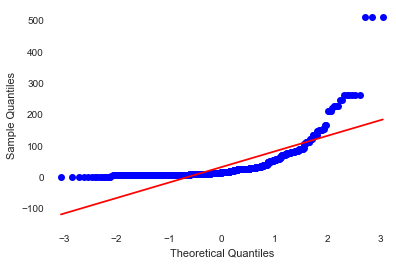

In [31]:
qqplot(train['Fare'], line='s')
plt.show()

In [32]:
train.shape

(891, 12)

In [33]:
test.shape

(418, 11)

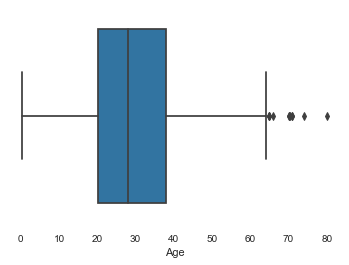

In [34]:
ax = sns.boxplot(x="Age", data=train)

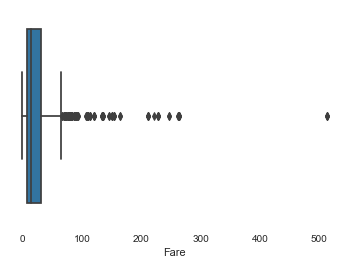

In [35]:
ax = sns.boxplot(x="Fare", data=train)

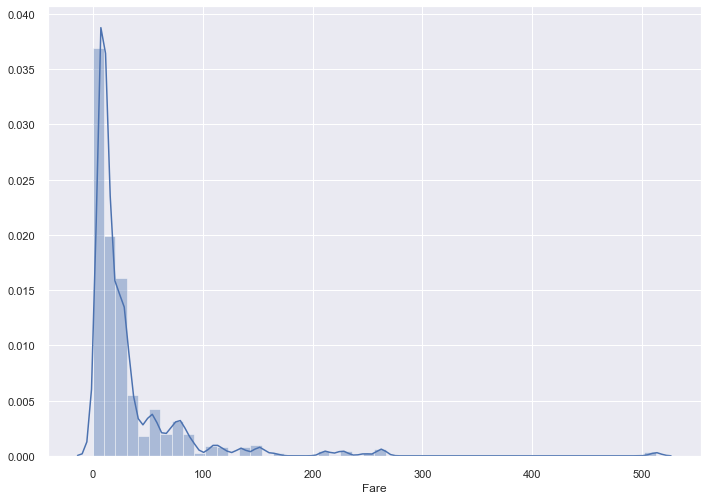

In [36]:
sns.set(color_codes=True)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(train['Fare'])

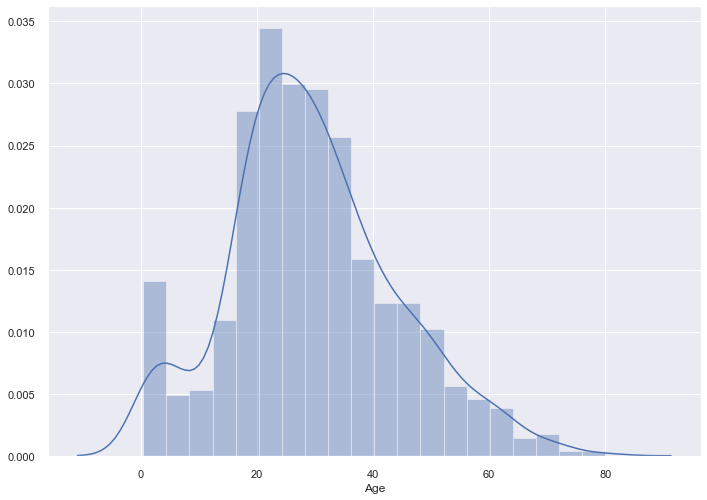

In [37]:
#Discretitzar edad, histograma
sns.set(color_codes=True)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(train['Age'])

# Anàlisi de les variables

In [38]:
mitja=train['Fare'].groupby([train['Pclass']]).mean()

In [39]:
suma=train['Fare'].groupby([train['Pclass']]).sum()

In [40]:
numero=train['Fare'].groupby([train['Pclass']]).count()

In [41]:
despesa = pd.concat([numero.rename('numero'), suma.rename('despesaTotal'), mitja.rename('mitja')], axis=1, sort=False)
despesa

,numero,despesaTotal,mitja
Pclass,,,
1,216,18177.4125,84.154687
2,184,3801.8417,20.662183
3,491,6714.6951,13.675550


In [42]:
despesa['cum_sumNum'] = despesa['numero'].cumsum()
despesa['cum_sumTot'] = despesa['despesaTotal'].cumsum()
despesa['percNum'] = 100*despesa['cum_sumNum']/despesa['numero'].sum()
despesa['percTot'] = 100*despesa['cum_sumTot']/despesa['despesaTotal'].sum()
despesa

,numero,despesaTotal,mitja,cum_sumNum,cum_sumTot,percNum,percTot
Pclass,,,,,,,
1,216,18177.4125,84.154687,216,18177.4125,24.242424,63.349288
2,184,3801.8417,20.662183,400,21979.2542,44.893378,76.598916
3,491,6714.6951,13.675550,891,28693.9493,100.000000,100.000000


## Outliers

C:\Users\marco\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\yellowbrick\regressor\influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "us

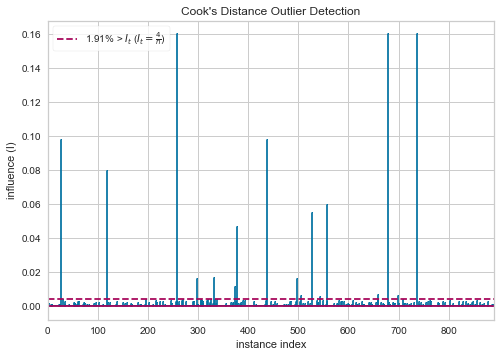

In [43]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete

X=np.asarray(train['Fare']).reshape(-1,1)
y=np.asarray(train['Survived'])
visualizer = CooksDistance()
visualizer.fit(X,y)
visualizer.show()


C:\Users\marco\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\marco\Anaconda3\lib\site-packages\yellowbrick\regressor\influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


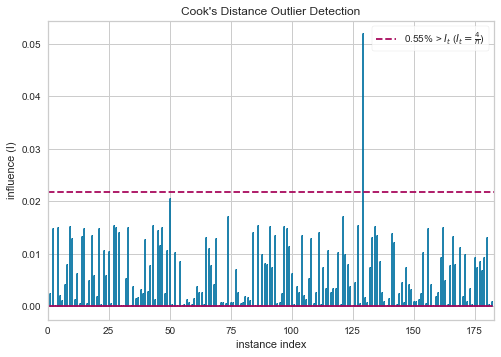

In [44]:
edat = pd.DataFrame(train.dropna())
X=np.asarray(edat['Age']).reshape(-1,1)
y=np.asarray(edat['Survived'])
visualizer = CooksDistance()
visualizer.fit(X,y)
visualizer.show()

## Avaluem la importància de les variables. Definim l'estratègia

In [45]:
#Avaluem algunes variables amb una regressió logística, Analitzem Pclass, Sex, Fare, Embarked
reglog = train.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket','Cabin'], axis=1) #Creem una dataset
reglog["Embarked"].fillna("S", inplace = True)  #Hi ha 2 na's a embarked. Per avaluar la varialb imputem majoria
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
reglog["Sex"] = enc.fit_transform(reglog["Sex"]) #Codifiquem 1,0 sexe
reglog["Embarked"] = enc.fit_transform(reglog["Embarked"]) #Codifiquem 0,1,2 on embarquen.
X_log = reglog.drop(['Survived'], axis=1)
y_log = reglog['Survived']
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
reglog_model = LogisticRegression(solver='liblinear', random_state=0)
reglog_model.fit(X_log, y_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
print(classification_report(y_log, reglog_model.predict(X_log)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       549
           1       0.73      0.69      0.71       342

    accuracy                           0.78       891
   macro avg       0.77      0.76      0.77       891
weighted avg       0.78      0.78      0.78       891



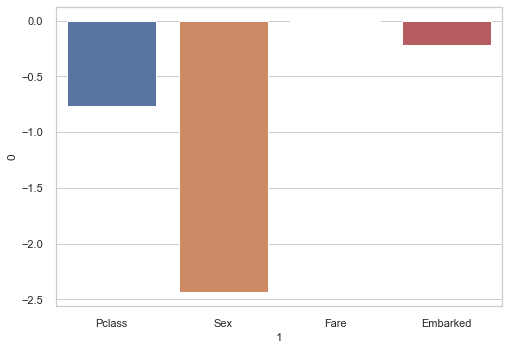

In [47]:
importance = reglog_model.coef_[0]
var_imp = pd.DataFrame(zip(importance,X_log.columns.values ))
sns.set(style='whitegrid')
ax = sns.barplot(x= var_imp[1], y= var_imp[0], data=var_imp)

In [48]:
#Discretitzem Fare amb cut, treballarem 10 trams que cada tram no te perquè tenir els mateixos integrants.
reglog['Fare']=train['Fare']
reglog['Fare_d']=pd.qcut(reglog['Fare'], 5, labels=range(5))
pd.crosstab(reglog.Fare_d, reglog.Survived, margins=True, normalize='columns')

Survived,0,1,All
Fare_d,,,
0,0.255009,0.114035,0.200898
1,0.267760,0.108187,0.206510
2,0.180328,0.213450,0.193042
3,0.182149,0.233918,0.202020
4,0.114754,0.330409,0.197531


In [49]:
#Tornem a avaluar el model, ara substituim la variable Fare_d x Fare
reglog['Fare']=train['Fare']
reglog['Fare_d']=pd.qcut(reglog['Fare'], 5, labels=range(5))
reglog=reglog.drop(['Fare'], axis=1)
X_log = reglog.drop(['Survived'], axis=1)
y_log = reglog['Survived']
reglog_model = LogisticRegression(solver='liblinear', random_state=0)
reglog_model.fit(X_log, y_log)
print(classification_report(y_log, reglog_model.predict(X_log)))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       549
           1       0.72      0.71      0.72       342

    accuracy                           0.78       891
   macro avg       0.77      0.77      0.77       891
weighted avg       0.78      0.78      0.78       891



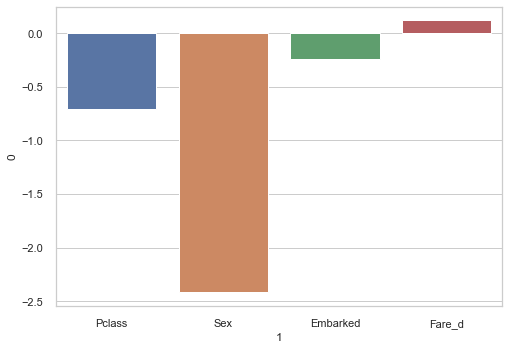

In [50]:
importance = reglog_model.coef_[0]
var_imp = pd.DataFrame(zip(importance,X_log.columns.values ))
sns.set(style='whitegrid')
ax = sns.barplot(x= var_imp[1], y= var_imp[0], data=var_imp)

In [51]:
#missing values, treballem la imputació de dades buides edat.
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [52]:
#Quina rlació hi ha entre cabin i fare? Podriem treballar els NA's de Cabin?
grup=train['Fare'].groupby([train['Pclass']])
grupmedia=grup.mean()

In [53]:
print(pd.DataFrame(grupmedia))

             Fare
Pclass           
1       84.154687
2       20.662183
3       13.675550


In [54]:
train['Fare'].corr(train['Pclass'])

-0.5494996199439078

In [55]:
#Ara tenim una base de dades amb 177 missing d'edat de 890 passatgers
#Podriem intuir edat per classe?
train['Age'].groupby([train['Pclass']]).mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [56]:
#Hem de començat amb les taules de contingència. Primer les obvies. Sex and Survival
pd.crosstab(train.Sex, train.Survived, margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


In [57]:
#Afegim classe
pd.crosstab([train.Sex, train.Survived], train.Pclass, margins=True, normalize='columns')

Pclass                  1         2         3       All
Sex    Survived                                        
female 0         0.013889  0.032609  0.146640  0.090909
       1         0.421296  0.380435  0.146640  0.261504
male   0         0.356481  0.494565  0.610998  0.525253
       1         0.208333  0.092391  0.095723  0.122334

# Discretització noves variables

In [58]:
#Anem a buscar 2 dades noves. Tenim els noms que ens indica que son casats o no. i també si son familia entre sí.
#1-casat (Mr), 2- casada (Mrs), 3- Soltera(Mss), 4-Master(jefe)
train['state']=train['Name'].apply(lambda x: 'Mr' if 'Mr.' in x else
                                            'Mr' if 'Don' in x else
                                             'Mr' if 'Major' in x else
                                           'Mrs' if 'Mrs.' in x else
                                           'Mrs' if 'Mrs' in x else
                                          'Mrs' if 'Countess' in x else
                                          'Mr' if 'Capt' in x else
                                          'Mr' if 'Jonkheer' in x else
                                           'Mr' if 'Rev' in x else
                                            'Mr' if 'Col' in x else
                                            'Mrs' if 'Mme' in x else
                                          'Miss' if 'Miss.' in x else
                                          'Miss' if 'Mlle' in x else
                                          'Miss' if 'Ms' in x else
                                           'Master' if 'Master' in x else
                                          'Mr' if 'Dr.' in x else 'Mr')


In [59]:
#hi ha tickets iguals, que corresponen a la mateixa familia, podem calcular número de viatgers que son familia. suma SibSp + Parch
train['family'] = train['SibSp']+ train['Parch']+1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,state,family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1


In [60]:
#Afegim state en lloc de Sex
pd.crosstab([ train.state], train.Survived, margins=True)

Survived,0,1,All
state,,,
Master,17,23,40
Miss,54,127,181
Mr,451,88,539
Mrs,27,104,131
All,549,342,891


In [61]:
#Propers càlculs. Discretitzar edat en franjes (ull viu missing data)
#Veiem que no hi ha correlació entre edat i despesa
train['Age'].corr(train['Fare'])

0.09606669176903887

In [62]:
perc=[0.15,0.3,0.45,0.6,0.75,0.9]
train['Age'].quantile(perc)

0.15    17.0
0.30    22.0
0.45    27.0
0.60    31.8
0.75    38.0
0.90    50.0
Name: Age, dtype: float64

In [63]:
#El que fem al discretitzar es substituir per un valor entre 0-6 en funció del percentil, hem creat 7 trams com hem vist abans.
#Fem el mateix amb Fare
train['edad']=pd.qcut(train['Age'], 7, labels=range(7))
train['Fare_d']=pd.qcut(train['Fare'], 5, labels=range(5))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,state,family,edad,Fare_d
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,5,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,4,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,4,1


In [64]:
#Avaluem edat/state/family, nº integrants de la familia. Molts anaven a la mateixa cabina.
pd.crosstab([ train.edad, train.state, train.Survived], train.family, margins=True)

family                  1    2   3   4   5   6   7  8  All
edad state  Survived                                      
0    Master 0           0    0   0   0   1   9   2  3   15
            1           0    3  13   4   0   0   1  0   21
     Miss   0           2    2   2   1   3   2   4  1   17
            1           9    8   7   7   0   0   2  0   33
     Mr     0          11    1   4   0   1   2   0  1   20
            1           1    0   2   0   0   0   0  0    3
     Mrs    1           0    4   0   0   0   0   0  0    4
1    Miss   0           4    3   1   0   1   0   0  0    9
            1           7    2   3   0   2   0   0  0   14
     Mr     0          45    5   4   0   0   1   0  0   55
            1           5    1   1   0   0   0   0  0    7
     Mrs    0           0    1   0   0   0   0   0  0    1
            1           1    4   0   0   0   0   0  0    5
2    Miss   0           5    1   0   0   0   0   0  0    6
            1          12    2   2   1   0   2   0  0   19
     Mr     0          48    8   3   3   0   0   0  0   62
            1           6    4   0   0   0   0   0  0   10
     Mrs    0           1    1   1   1   0   0   0  0    4
            1           3    4   3   3   0   1   0  0   14
3    Miss   0           2    0   0   0   0   0   0  0    2
            1          13    1   0   0   0   0   0  0   14
     Mr     0          35   10   2   0   0   0   0  0   47
            1          11    1   0   0   0   0   0  0   12
     Mrs    0           0    1   3   0   1   0   0  0    5
            1           2    5   2   1   0   0   0  0   10
4    Miss   0           2    0   0   0   0   0   0  0    2
            1           8    2   2   0   0   0   0  0   12
     Mr     0          39    8   6   1   0   0   0  0   54
            1          15    3   0   1   0   0   0  0   19
     Mrs    0           0    1   1   0   0   0   0  0    2
            1           5    8   5   3   0   0   0  0   21
5    Miss   0           3    0   0   0   0   0   0  0    3
            1           6    0   1   0   0   0   0  0    7
     Mr     0          29   10   7   0   0   1   1  0   48
            1           7    2   1   0   0   0   0  0   10
     Mrs    0           0    3   1   0   0   3   1  1    9
            1           4    6   6   0   0   0   1  0   17
6    Miss   0           1    0   0   0   0   0   0  0    1
            1           4    2   0   0   0   0   0  0    6
     Mr     0          46    7   5   0   0   1   0  0   59
            1           7    4   2   0   0   0   0  0   13
     Mrs    0           1    1   0   0   1   0   0  0    3
            1           4   10   3   1   1   0   0  0   19
All                   404  139  93  27  11  22  12  6  714

In [65]:
#Arribat a aquest punt podem imputar els valors missing en l'edat, però ho farem amb les mitjanes dels grups que pertànyin.
#Primer calculem la edat mitja dels grups que creem
train.groupby(['Pclass', 'state'])[['Age']].describe()

Age                                                        
               count       mean        std    min    25%   50%     75%   max
Pclass state                                                                
1      Master    3.0   5.306667   5.165475   0.92   2.46   4.0   7.500  11.0
       Miss     46.0  29.869565  12.739455   2.00  21.25  30.0  36.000  63.0
       Mr       99.0  42.449495  13.890699  17.00  31.00  42.0  51.000  80.0
       Mrs      38.0  39.973684  12.656559  17.00  33.50  39.5  49.750  62.0
2      Master    9.0   2.258889   2.342634   0.67   0.83   1.0   3.000   8.0
       Miss     30.0  23.116667  13.569542   2.00  14.00  24.5  31.875  50.0
       Mr       91.0  33.307692  12.481491   8.00  24.50  31.0  39.000  70.0
       Mrs      43.0  33.116279  10.413383  14.00  24.50  31.0  40.500  57.0
3      Master   24.0   5.350833   3.593608   0.42   2.00   4.0   9.000  12.0
       Miss     69.0  16.123188   9.697315   0.75   9.00  18.0  22.000  45.0
       Mr      229.0  28.724891  10.490946  11.00  21.00  26.0  34.000  74.0
       Mrs      33.0  33.515152  10.031579  15.00  27.00  31.0  40.000  63.0

In [66]:
#Farem el seguent. fem copia 'Age', i posarem 0 les nan. avaluarem les característiques i imputarem una edad en funció del grup.
train['Age2']=train['Age']
train['Age2'].fillna(0,inplace=True)
Edad = train[train['Age2']== 0]
#Per problemes amb Python replace amb iloc, where... TypeError: unsupported operand type(s) for &: 'str' and 'Categorical' Creo 3 dataframes
Edad1 = Edad[Edad['Pclass'] == 1]
Edad2 = Edad[Edad['Pclass'] == 2]
Edad3 = Edad[Edad['Pclass'] == 3]

In [67]:
#Els 177 missing, distribució
pd.crosstab([ Edad.Pclass, Edad.state], Edad.Survived, margins=True)

Survived         0   1  All
Pclass state               
1      Miss      0   1    1
       Mr       16   5   21
       Mrs       0   8    8
2      Miss      0   2    2
       Mr        7   2    9
3      Master    2   2    4
       Miss     14  19   33
       Mr       83   7   90
       Mrs       3   6    9
All            125  52  177

In [68]:
#Ara si, faig el "replacement" en funció dels valors mitjos del grup a qui pertanyin.
Edad1.loc[(Edad.state == 'Miss'), 'Age'] = 30
Edad1.loc[(Edad.state == 'Mr'), 'Age'] = 42
Edad1.loc[(Edad.state == 'Mrs'), 'Age'] = 40
Edad2.loc[(Edad.state == 'Miss'), 'Age'] = 23
Edad2.loc[(Edad.state == 'Mr'), 'Age'] = 33
Edad3.loc[(Edad.state == 'Master'), 'Age'] = 5
Edad3.loc[(Edad.state == 'Miss'), 'Age'] = 16
Edad3.loc[(Edad.state == 'Mr'), 'Age'] = 29
Edad3.loc[(Edad.state == 'Mrs'), 'Age'] = 33


C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [69]:
#imputem els valors calculats 

index1=Edad1.index.values
index2=Edad2.index.values
index3=Edad3.index.values

#Incorporem les noves dades imputades a la dataset train
for i in index1:
    train['Age'][i] = Edad1['Age'][i]
for i in index2:
    train['Age'][i] = Edad2['Age'][i]
for i in index3:
    train['Age'][i] = Edad3['Age'][i]

C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path

In [70]:
#Avaluem age amb el model de regressió
reglog['Age']=train['Age']
reglog['edad']=pd.qcut(reglog['Age'], 7, labels=range(7))
reglog=reglog.drop(['Age'], axis=1)
X_log = reglog.drop(['Survived'], axis=1)
y_log = reglog['Survived']
reglog_model = LogisticRegression(solver='liblinear', random_state=0)
reglog_model.fit(X_log, y_log)
print(classification_report(y_log, reglog_model.predict(X_log)))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       549
           1       0.75      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.78       891
weighted avg       0.80      0.80      0.80       891



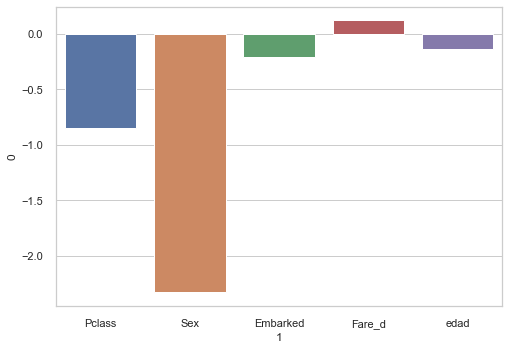

In [71]:
importance = reglog_model.coef_[0]
var_imp = pd.DataFrame(zip(importance,X_log.columns.values ))
sns.set(style='whitegrid')
ax = sns.barplot(x= var_imp[1], y= var_imp[0], data=var_imp)

In [72]:
#Ara tornem a imputar edad, ja que tenim Age sense missing.
train['edad']=pd.qcut(train['Age'], 6, labels=range(0,6))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,state,family,edad,Fare_d,Age2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,1,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,4,4,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,2,1,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,4,4,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,4,1,35.0


In [73]:
#Comprovem na's. Tenim 2 Embarked i la majoria de Cabin.
#Fare té una relació molt alta amb Pclass, i Ticket ja indica si viatgen junts o no (també el nº family)
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
state            0
family           0
edad             0
Fare_d           0
Age2             0
dtype: int64

In [74]:
#Ara ja només tenim missing en la variable 'Cabin', que son moltíssimes (687) i tampoc ens ofereix informació que no tingui ticket. = ticket = Cabin.
# Ja podem preparar la dataset per entrenament.
# Fem les modificacions que hem fet a train per test.

#Creem variable 'state'
test['state']=test['Name'].apply(lambda x: 'Mr' if 'Mr.' in x else
                                            'Mr' if 'Don' in x else
                                             'Mr' if 'Major' in x else
                                           'Mrs' if 'Mrs.' in x else
                                           'Mrs' if 'Mrs' in x else
                                          'Mrs' if 'Countess' in x else
                                          'Mr' if 'Capt' in x else
                                          'Mr' if 'Jonkheer' in x else
                                           'Mr' if 'Rev' in x else
                                            'Mr' if 'Col' in x else
                                            'Mrs' if 'Mme' in x else
                                          'Miss' if 'Miss.' in x else
                                          'Miss' if 'Mlle' in x else
                                          'Miss' if 'Ms' in x else
                                           'Master' if 'Master' in x else
                                          'Mr' if 'Dr.' in x else 'Mr')
#Afegim 'family'
test['family'] = test['SibSp']+ test['Parch']+1
#Modifiquem Age
#Farem el seguent. fem copia 'Age', i posarem 0 les nan. avaluarem les característiques i imputarem una edad en funció del grup.
test['Age2']=test['Age']
test['Age2'].fillna(0,inplace=True)
Edad = test[test['Age2']== 0]

Edad1 = Edad[Edad['Pclass'] == 1]
Edad2 = Edad[Edad['Pclass'] == 2]
Edad3 = Edad[Edad['Pclass'] == 3]

Edad1.loc[(Edad.state == 'Miss'), 'Age'] = 30
Edad1.loc[(Edad.state == 'Mr'), 'Age'] = 42
Edad1.loc[(Edad.state == 'Mrs'), 'Age'] = 40
Edad2.loc[(Edad.state == 'Miss'), 'Age'] = 23
Edad2.loc[(Edad.state == 'Mr'), 'Age'] = 33
Edad3.loc[(Edad.state == 'Master'), 'Age'] = 5
Edad3.loc[(Edad.state == 'Miss'), 'Age'] = 16
Edad3.loc[(Edad.state == 'Mr'), 'Age'] = 29
Edad3.loc[(Edad.state == 'Mrs'), 'Age'] = 33

index1=Edad1.index.values
index2=Edad2.index.values
index3=Edad3.index.values

for i in index1:
    test['Age'][i] = Edad1['Age'][i]
for i in index2:
    test['Age'][i] = Edad2['Age'][i]
for i in index3:
    test['Age'][i] = Edad3['Age'][i]
    
perc=[0.15,0.3,0.45,0.6,0.75,0.9]
test['Age'].quantile(perc)

test['edad']=pd.qcut(test['Age'], 6, labels=range(0,6))

C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\marco\Anac

In [75]:
#Columnes que eliminem
col = ['PassengerId', 'Name', 'Age', 'Ticket', 'Cabin', 'Age2', 'Fare']
train = train.drop(col, axis=1)
test = test. drop(col, axis=1)

In [76]:
#Convertim en "ojbect" les variables categòriques per poder fer pre-processament

col=['Pclass', 'Sex', 'edad', 'Fare_d']
train[col] = train[col].astype(str)
train['Survived']= train['Survived'].astype('category')

In [77]:
train.dtypes

Survived    category
Pclass        object
Sex           object
SibSp          int64
Parch          int64
Embarked      object
state         object
family         int64
edad          object
Fare_d        object
dtype: object

# avaluació Chi quadrat de les taules de contingència

In [99]:
import researchpy

#Podem crear una taula de contingència amb els percentatges directament
researchpy.crosstab(train['Survived'], train['Pclass'], prop= "cell")

Pclass                      
Pclass        1      2      3     All
Survived                             
0          8.98  10.89  41.75   61.62
1         15.26   9.76  13.36   38.38
All       24.24  20.65  55.11  100.00

In [100]:
# Per files
researchpy.crosstab(train['Survived'], train['Pclass'], prop= "row")

Pclass                     
Pclass        1      2      3    All
Survived                            
0         14.57  17.67  67.76  100.0
1         39.77  25.44  34.80  100.0
All       24.24  20.65  55.11  100.0

In [102]:
#O per columnes
researchpy.crosstab(train['Survived'], train['Pclass'], prop= "col")

Pclass                        
Pclass         1       2       3     All
Survived                                
0          37.04   52.72   75.76   61.62
1          62.96   47.28   24.24   38.38
All       100.00  100.00  100.00  100.00

In [104]:
#Però també podem avaluar l'anàlisi d'independència amb chi quadrat directament.
researchpy.crosstab(train['Survived'], train['Pclass'], prop='col', test= "chi-square")

(          Pclass                        
 Pclass         1       2       3     All
 Survived                                
 0          37.04   52.72   75.76   61.62
 1          62.96   47.28   24.24   38.38
 All       100.00  100.00  100.00  100.00,
                 Chi-square test   results
 0  Pearson Chi-square ( 2.0) =   102.8890
 1                    p-value =     0.0000
 2                 Cramer's V =     0.3398)

### La interpretació del resultat

Ens ofereix el quadre de contingència amb les proporcions per columnes.

Pearson Chi-square ( 2.0) =   102.8890 es el valor de l'estadístic.

p-value =     0.0000 indica la significància de la independència de les variables. p<0.05 hi ha una dependència.

Cramer's V =     0.3398 per valors majors a 0.5 indica una associació forta. Amb valors 0.3-0.5 associació moderada.

In [191]:
#Preparem les taules
categorical_features = train.select_dtypes(include=['object']).columns
taula=[]
pvalue=[]
cramer=[]
for i in categorical_features:
    res = researchpy.crosstab(train['Survived'], train[i], prop='col', test='chi-square')
    taula.append(res[0])
    pvalue.append(res[1].iloc[1])
    cramer.append(res[1].iloc[2])

In [192]:
cramer=pd.DataFrame(cramer)
cramer['variables'] = categorical_features
cramer

,Chi-square test,results,variables
2,Cramer's V =,0.3398,Pclass
2,Cramer's phi =,0.5434,Sex
2,Cramer's V =,0.1726,Embarked
2,Cramer's V =,0.5680,state
2,Cramer's V =,0.2139,edad
2,Cramer's V =,0.3357,Fare_d


In [196]:
#Totes les taules de contingència
taula

[          Pclass                        
 Pclass         1       2       3     All
 Survived                                
 0          37.04   52.72   75.76   61.62
 1          62.96   47.28   24.24   38.38
 All       100.00  100.00  100.00  100.00,
             Sex                
 Sex      female    male     All
 Survived                       
 0          25.8   81.11   61.62
 1          74.2   18.89   38.38
 All       100.0  100.00  100.00,
          Embarked                       
 Embarked        C       Q      S     All
 Survived                                
 0           44.64   61.04   66.3   61.75
 1           55.36   38.96   33.7   38.25
 All        100.00  100.00  100.0  100.00,
           state                                
 state    Master    Miss      Mr     Mrs     All
 Survived                                       
 0          42.5   29.83   83.67   20.61   61.62
 1          57.5   70.17   16.33   79.39   38.38
 All       100.0  100.00  100.00  100.00  100.00,


# Avaluació de classificadors

In [78]:
#https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
#Ara avaluem quin model pot ser millor.

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Tenim 2 na en Emarked, les imputarem mitjançant SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [79]:
#Dividim variables entre numériques i categòriques.

numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).columns

from sklearn.compose import ColumnTransformer
#Es realitza la imputació, i la standarització de les variables numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [80]:
#Aquí creem la dataset per l'entrenament.
all_features = train.drop("Survived",axis=1)
Targeted_feature = train["Survived"]

#Dividim train dataset en train i test, amb un 25% al grup test.

X_train, X_test, y_train, y_test = train_test_split(all_features,Targeted_feature,test_size=0.25,random_state=12)


In [81]:
#Fem una primera aproximaxió amb RandomForest preparem la dataset amb les passes donades.

from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())]) #El model amb les dades pre-processades

In [82]:
#Entrenem 
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [83]:
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)

0.7847533632286996

In [84]:
len(y_pred)

223

In [87]:
#GridSearch KNeighborsClassifier, ni millora 0.77
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

kn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])
param_grid = { 
    'classifier__n_neighbors': [11,13,15],
    'classifier__leaf_size': [1,2,3],
    }
from sklearn.model_selection import GridSearchCV
GSkn = GridSearchCV(kn, param_grid, n_jobs= 1)
                  
GSkn.fit(X_train, y_train)  
print(GSkn.best_params_)    
print(GSkn.best_score_)
print("model score: %.3f" % GSkn.score(X_test, y_test))

{'classifier__leaf_size': 2, 'classifier__n_neighbors': 13}
0.8323644933228594
model score: 0.771


In [91]:
#GridSearch SVC
svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
param_grid = { 
    
    'classifier__gamma': [0.08,0.1,0.2],
    'classifier__C': [0.8,1,1.2,2],
    }
from sklearn.model_selection import GridSearchCV
GSsvc = GridSearchCV(svc, param_grid, n_jobs= 1)
                  
GSsvc.fit(X_train, y_train)  
print(GSsvc.best_params_)    
print(GSsvc.best_score_)
print("model score: %.3f" % GSsvc.score(X_test, y_test))

{'classifier__C': 1, 'classifier__gamma': 0.1}
0.8443496801705758
model score: 0.798


In [88]:
#GridSearch nuSVC
nusvc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', NuSVC())])
param_grid = { 
    'classifier__decision_function_shape': ['ovo', 'ovr'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__nu': [0.2,0.3,0.5],
    'classifier__kernel': ['linear', 'rbf'],
    }
from sklearn.model_selection import GridSearchCV
GSnusvc = GridSearchCV(nusvc, param_grid, n_jobs= 1)
                  
GSnusvc.fit(X_train, y_train)  
print(GSnusvc.best_params_)    
print(GSnusvc.best_score_)
print("model score: %.3f" % GSnusvc.score(X_test, y_test))

{'classifier__decision_function_shape': 'ovo', 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__nu': 0.3}
0.8368196610930312
model score: 0.762


In [66]:
#GridSearch DecisionClassifier

dtc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])
param_grid = { 
    'classifier__max_depth': [5,7,10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_samples_split': [3,4,5],
    }
from sklearn.model_selection import GridSearchCV
GSdtc = GridSearchCV(dtc, param_grid, n_jobs= 1)
                  
GSdtc.fit(X_train, y_train)  
print(GSdtc.best_params_)    
print(GSdtc.best_score_)
print("model score: %.3f" % GSdtc.score(X_test, y_test))

{'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 3}
0.83088317809449
model score: 0.794


In [67]:
#Ja hem entrenat abans. rf es definit GridSearch RandomForest
param_grid = { 
    'classifier__n_estimators': [100,200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy'],
    'classifier__min_samples_split' :[2,3,4,5]}
from sklearn.model_selection import GridSearchCV
GSrf = GridSearchCV(rf, param_grid, n_jobs= 1)
                  
GSrf.fit(X_train, y_train)  
print(GSrf.best_params_)    
print(GSrf.best_score_)
print("model score: %.3f" % GSrf.score(X_test, y_test))

{'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 4, 'classifier__n_estimators': 200}
0.8518123667377399
model score: 0.794


In [68]:
#GridSearch AdaBoostClassifier

DTC=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

abc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', AdaBoostClassifier(base_estimator=DTC))])
param_grid = { 
    'classifier__n_estimators':[10,20],
    'classifier__learning_rate': [0.001, 0.005,0.01]

    }
from sklearn.model_selection import GridSearchCV
GSabc = GridSearchCV(abc, param_grid, n_jobs= 1)
                  
GSabc.fit(X_train, y_train)  
print(GSabc.best_params_)    
print(GSabc.best_score_)
print("model score: %.3f" % GSabc.score(X_test, y_test))

{'classifier__learning_rate': 0.005, 'classifier__n_estimators': 20}
0.8398159578049601
model score: 0.785


In [89]:
#GridSearch GradientBoostingClassifier

gbc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])
param_grid = { 
    'classifier__learning_rate': [0.04, 0.05, 0.06],
    'classifier__max_depth': [5,8,15],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [7,8,10],
    'classifier__n_estimators': [15,20,40]
    }
from sklearn.model_selection import GridSearchCV
GSgbc = GridSearchCV(gbc, param_grid, n_jobs= 1)
                  
GSgbc.fit(X_train, y_train)  
print(GSgbc.best_params_)    
print(GSgbc.best_score_)
print("model score: %.3f" % GSgbc.score(X_test, y_test))

{'classifier__learning_rate': 0.04, 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 8, 'classifier__n_estimators': 20}
0.8517787004825497
model score: 0.780


In [80]:
#GridSearch Logistic Regression
lgr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
param_grid = { 
    'classifier__solver': ['newton-cg', 'lbfgs',  'sag', 'saga'],
    'classifier__max_iter':[500],
    'classifier__multi_class': ['auto', 'ovr', 'multinomial'],
    'classifier__penalty': ['l2'],
    'classifier__C': [1,1.2,2],
    }
from sklearn.model_selection import GridSearchCV
GSlgr = GridSearchCV(lgr, param_grid, n_jobs= 1)
                  
GSlgr.fit(X_train, y_train)  
print(GSlgr.best_params_)    
print(GSlgr.best_score_)
print("model score: %.3f" % GSlgr.score(X_test, y_test))

{'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__multi_class': 'multinomial', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
0.8204129727303332
model score: 0.834


In [93]:
#GridSearch XGBoostClassifier NO millora 0.807

xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])
param_grid = { 
    'classifier__objective': ['binary:logistic'],
    'classifier__gamma': [0, 1, 2],
    'classifier__colsample_bytree': [0.4, 0.6,1],
    'classifier__max_depth': [ 4, 5, 6],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.005],
    }
from sklearn.model_selection import GridSearchCV
GSxgb = GridSearchCV(xgb, param_grid, n_jobs= 1)
                  
GSxgb.fit(X_train, y_train)  
print(GSxgb.best_params_)    
print(GSxgb.best_score_)
print("model score: %.3f" % GSxgb.score(X_test, y_test))

{'classifier__colsample_bytree': 1, 'classifier__gamma': 1, 'classifier__learning_rate': 0.005, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__objective': 'binary:logistic'}
0.8533049040511728
model score: 0.771


In [204]:
#Un cop treballat tunning amb els classificadors, fem el Pipeline



#Valor per configurar AdaBoost
DTC = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',  min_samples_split=4)

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="rbf", C=1, probability=True, gamma=0.1),
    NuSVC(decision_function_shape='ovo', gamma='scale', kernel='rbf',
       nu=0.5, probability=True ),
    DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',  min_samples_split=4),
    RandomForestClassifier(criterion='gini', max_depth=6, max_features='auto',
                       n_estimators=200),
    AdaBoostClassifier(base_estimator=DTC,learning_rate=0.01, n_estimators=20 ),
    GradientBoostingClassifier(
                           learning_rate=0.06,  max_depth=8,
                           max_features='sqrt',
                           min_samples_split=8,
                           n_estimators=40,
                           ),
    LogisticRegression(C=1,  max_iter=500, multi_class='multinomial', penalty='l2', solver='newton-cg'),
    XGBClassifier(max_depth=8, n_estimators=200, learning_rate=0.02, objective='binary:logistic')
    ]

predicted = []
Scores =[]

for classifier in classifiers:    
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)  
    pred = pipe.predict(X_test)
    predicted.append(pred)
    Scores.append(pipe.score(X_test, y_test))
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    
    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
model score: 0.785
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model score: 0.798
NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
model score: 0.825
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       m

In [95]:
#Preparem un resum en un dataframe

Models =['KNeighborsClassifier', 'SVC','NuSVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 
         'AdaBoostClassifier', 'GradientBoostingClassifier', 'LogisticRegression', 'XGBClassifier' ]

Resultats = pd.DataFrame(list(zip(Models,Scores)), columns=['Models', 'Scores'])

In [96]:
Resultats

,Models,Scores
0,KNeighborsClassifier,0.784753
1,SVC,0.798206
2,NuSVC,0.825112
3,DecisionTreeClassifier,0.780269
4,RandomForestClassifier,0.811659
5,AdaBoostClassifier,0.802691
6,GradientBoostingClassifier,0.784753
7,LogisticRegression,0.834081
8,XGBClassifier,0.793722


In [218]:
# Stacking, seleccionem el millor score com model base. LogisticRegression (0.839)
# Agafem prediccions de models que entenguem que puguin ser linelalment independents de les LR
# Seleccionem, NuSVC, RandomForest, XGBoostClassifier
# Les prdiccions les hem guardat a la llista predicted

#Prediccions per NuSVC
pred_NuSVC = predicted[2].reshape(-1,1) #Convertim en columna, després one hot encoder
pred_rf = predicted[4].reshape(-1,1)
pred_abc = predicted[5].reshape(-1,1)
pred_xgb = predicted[8].reshape(-1,1)
enc=OneHotEncoder(categories='auto') #Convertim en OHE
#One Hote Encoding de cada predicció
enc.fit(pred_NuSVC)
Nu_SVC_oe=enc.transform(pred_NuSVC).toarray()
enc.fit(pred_rf)
rf_oe=enc.transform(pred_rf).toarray()
enc.fit(pred_abc)
abc_oe=enc.transform(pred_abc).toarray()
enc.fit(pred_xgb)
xgb_oe=enc.transform(pred_xgb).toarray()

In [219]:
#Creem una matriu amb les prediccions.
meta=np.column_stack((Nu_SVC_oe,rf_oe, xgb_oe, abc_oe ))

In [220]:
#Les 6 columnes de les 3 prediccions one hot amb les 223 rows from test
print(meta.shape)

(223, 8)


In [221]:
LRs=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False).fit(meta, y_test)
scores_LRs=cross_val_score(LRs, meta, y_test, cv=3)
scores_LRs

array([0.77333333, 0.7972973 , 0.85135135])

In [222]:
y_pred = LRs.predict(meta)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.83856502]


In [223]:
#Cascading , afegim variables x_test a les prediccions

meta1=np.column_stack((meta,X_test))
print(meta1.shape)

(223, 17)


In [224]:
#hi ha un sol missing value a Embarked.
X_test.fillna('S', inplace=True)

C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [225]:
#Estem pasam onehotencoder les variables categoriques
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_test[categorical_features])
ohe = enc.fit_transform(X_test[categorical_features]).toarray()

In [226]:
meta1=np.column_stack((X_test[numeric_features], ohe, meta))

In [227]:
LRc=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False).fit(meta1, y_test)
scores_svc2=cross_val_score(LRc, meta1, y_test, cv=3)
scores_svc2

array([0.73333333, 0.81081081, 0.87837838])

In [228]:
LRc.fit(meta1, y_test)
y_pred = LRc.predict(meta1)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.85201794]


In [230]:
#Finalment amb cascading augmento score de 0.83 a 0.85
print(classification_report(y_test, LRc.predict(meta1)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       130
           1       0.85      0.78      0.82        93

    accuracy                           0.85       223
   macro avg       0.85      0.84      0.85       223
weighted avg       0.85      0.85      0.85       223

